# Figures for Thesis Results

This notebook aggregates pulse outputs from CMA-ES and GRAPE runs, resamples them to a shared time grid, and rescales the pulse areas so that each Omega channel integrates to $4\pi$.


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qutip as qt
from matplotlib.lines import Line2D
from pathlib import Path
from collections import defaultdict
from warnings import warn
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

In [102]:
BASE_DIR = Path('/home/yehon/projects/grape-crab-qoc')
RESULT_DIRS = {
    'CMA-ES': BASE_DIR / 'notebooks' / 'results' / 'CMA-ES',
    'GRAPE': BASE_DIR / 'notebooks' / 'results' / 'GRAPE',
}
OUTPUT_DIR = BASE_DIR / 'results' / 'results'

CANONICAL_DURATION = 0.1
CANONICAL_POINTS = 2000
CANONICAL_T = np.linspace(0.0, CANONICAL_DURATION, CANONICAL_POINTS)

TARGETS = ['original', 'terminal', 'adiabatic', 'ensemble']
TARGET_ALIASES = {
    'original': ['original', 'baseline'],
    'terminal': ['terminal', 'fidelity'],
    'adiabatic': ['adiabatic', 'path'],
    'ensemble': ['ensemble'],
}
CHANNELS = ['omega', 'delta']
CHANNEL_ALIASES = {
    'omega': ['omega'],
    'delta': ['delta'],
}

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Artifacts will be written to: {OUTPUT_DIR}')

Artifacts will be written to: /home/yehon/projects/grape-crab-qoc/results/results


In [103]:
COLOR_MAP = {
    'original': '#1f77b4',  # blue
    'terminal': '#ff7f0e',  # orange
    'adiabatic': '#2ca02c',  # green
    'ensemble': '#d62728',  # red
    'path': '#9467bd',  # purple
}

TARGET_DISPLAY_NAMES = {
    'original': 'Original',
    'terminal': 'Terminal',
    'adiabatic': 'Adiabatic',
    'ensemble': 'Ensemble',
    'path': 'Path',
}

TIME_LABEL = r'Time ($\mu s$)'


def color_for(target: str) -> str:
    return COLOR_MAP.get(target, '#7f7f7f')


def display_name(target: str) -> str:
    return TARGET_DISPLAY_NAMES.get(target, target.title())

In [104]:
def iter_pulse_files(directory: Path):
    for path in directory.glob('*.npy'):
        if path.is_file():
            yield path


def resolve_pulse_file(directory: Path, target: str, channel: str) -> Path:
    target_aliases = [alias.lower() for alias in TARGET_ALIASES[target]]
    channel_aliases = [alias.lower() for alias in CHANNEL_ALIASES[channel]]
    for pulse_path in iter_pulse_files(directory):
        name = pulse_path.name.lower()
        if any(alias in name for alias in target_aliases) and any(alias in name for alias in channel_aliases):
            return pulse_path
    target_desc = ', '.join(target_aliases)
    channel_desc = ', '.join(channel_aliases)
    raise FileNotFoundError(f'No {channel} pulse for target "{target}" (aliases: {target_desc}) in {directory}')


def load_and_resample(path: Path, canonical_t: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    raw = np.load(path)
    if raw.ndim != 1:
        raise ValueError(f'Expected 1D pulse in {path}, received shape {raw.shape}')
    original_t = np.linspace(canonical_t[0], canonical_t[-1], raw.size)
    resampled = np.interp(canonical_t, original_t, raw)
    return raw, resampled


def scale_pulses(omega: np.ndarray, delta: np.ndarray, canonical_t: np.ndarray) -> tuple[float, np.ndarray, np.ndarray, float, float]:
    area = np.trapezoid(omega, canonical_t)
    if np.isclose(area, 0.0):
        warn('Omega area is approximately zero; skipping rescale and leaving pulses unchanged.')
        scale = 1.0
    else:
        scale = 1.0 #4 * np.pi / area
    omega_scaled = omega * scale
    delta_scaled = delta# * scale
    scaled_area = np.trapezoid(omega_scaled, canonical_t)
    return scale, omega_scaled, delta_scaled, area, scaled_area


def slugify(*parts: str) -> str:
    return '_'.join(part.lower().replace('-', '_') for part in parts)


In [105]:
resampled_pulses: dict[str, dict[str, dict[str, np.ndarray]]] = defaultdict(dict)
summary_rows: list[dict[str, float]] = []
missing_entries: list[str] = []

for algorithm, directory in RESULT_DIRS.items():
    if not directory.exists():
        warn(f'Skipping {algorithm}: directory {directory} not found.')
        continue
    for target in TARGETS:
        try:
            omega_path = resolve_pulse_file(directory, target, 'omega')
        except FileNotFoundError as exc:
            missing_entries.append(f'{algorithm} | {target} | omega')
            warn(str(exc))
            continue
        try:
            delta_path = resolve_pulse_file(directory, target, 'delta')
        except FileNotFoundError as exc:
            missing_entries.append(f'{algorithm} | {target} | delta')
            warn(str(exc))
            continue

        _, omega_resampled = load_and_resample(omega_path, CANONICAL_T)
        _, delta_resampled = load_and_resample(delta_path, CANONICAL_T)

        scale, omega_scaled, delta_scaled, area_before, area_after = scale_pulses(
            omega_resampled, delta_resampled, CANONICAL_T
        )

        resampled_pulses[algorithm][target] = {
            'omega': omega_scaled,
            'delta': delta_scaled,
            'scale_factor': scale,
            'area_before': area_before,
            'area_after': area_after,
        }

        summary_rows.append(
            {
                'algorithm': algorithm,
                'target': target,
                'omega_file': omega_path.name,
                'delta_file': delta_path.name,
                'scale_factor': scale,
                'area_before': area_before,
                'area_after': area_after,
            }
        )

summary_df = pd.DataFrame(summary_rows)
summary_df

,algorithm,target,omega_file,delta_file,scale_factor,area_before,area_after
0,CMA-ES,original,Omega_Original.npy,Delta_Original_base.npy,1.0,12.566371,12.566371
1,CMA-ES,terminal,Omega_Fidelity.npy,Delta_Fidelity.npy,1.0,12.392210,12.392210
2,CMA-ES,adiabatic,Omega_Adiabatic.npy,Delta_Adiabatic.npy,1.0,12.492949,12.492949
3,CMA-ES,ensemble,Omega_Ensemble.npy,Delta_Ensemble.npy,1.0,9.758240,9.758240
4,GRAPE,original,OMEGA_baseline.npy,DELTA_baseline.npy,1.0,12.566371,12.566371
5,GRAPE,terminal,OMEGA_terminal.npy,DELTA_terminal.npy,1.0,13.435369,13.435369
6,GRAPE,adiabatic,OMEGA_path.npy,DELTA_path.npy,1.0,13.742381,13.742381
7,GRAPE,ensemble,OMEGA_ensemble.npy,DELTA_ensemble.npy,1.0,11.948774,11.948774


In [106]:
for algorithm, targets_dict in resampled_pulses.items():
    if not targets_dict:
        continue
    data = {'t': CANONICAL_T}
    for target, pulse_dict in targets_dict.items():
        slug = slugify(target)
        data[f'{slug}_omega'] = pulse_dict['omega']
        data[f'{slug}_delta'] = pulse_dict['delta']
    output_path = OUTPUT_DIR / f'{slugify(algorithm)}_rescaled_pulses.npz'
    np.savez(output_path, **data)
    print(f'Saved {output_path}')

summary_path = OUTPUT_DIR / 'pulse_scaling_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f'Saved {summary_path}')

if missing_entries:
    print('Missing pulse entries:')
    for item in missing_entries:
        print(f' - {item}')


Saved /home/yehon/projects/grape-crab-qoc/results/results/cma_es_rescaled_pulses.npz
Saved /home/yehon/projects/grape-crab-qoc/results/results/grape_rescaled_pulses.npz
Saved /home/yehon/projects/grape-crab-qoc/results/results/pulse_scaling_summary.csv


Saved overlay figure to /home/yehon/projects/grape-crab-qoc/results/results/pulse_overlay.png
Saved overlay figure to /home/yehon/projects/grape-crab-qoc/results/results/pulse_overlay.pdf


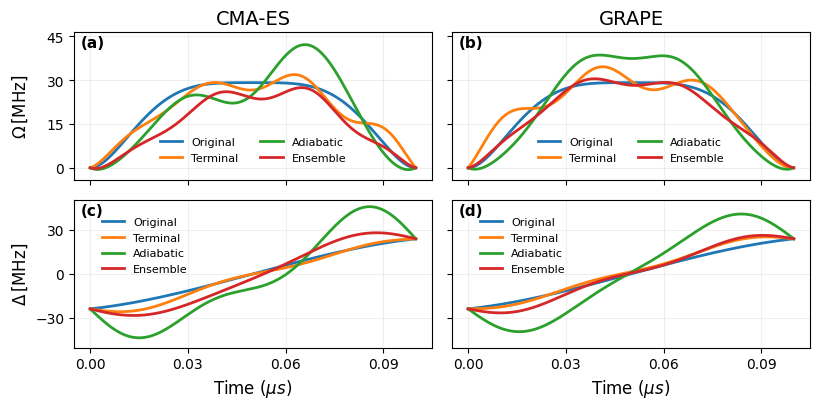

In [107]:
fig, axes = plt.subplots(2, 2, figsize=(8.3, 4.2), sharex=True)

ylim_value_omega = 0.0
ylim_value_delta = 0.0

for col, algorithm in enumerate(['CMA-ES', 'GRAPE']):
    algorithm_pulses = resampled_pulses.get(algorithm, {})

    for target in TARGETS:
        pulse_entry = algorithm_pulses.get(target)
        if not pulse_entry:
            continue

        time_axis = CANONICAL_T

        axes[0, col].plot(time_axis, pulse_entry['omega']/(2*np.pi), color=color_for(target), label=display_name(target), linewidth=2)
        axes[1, col].plot(time_axis, pulse_entry['delta']/(2*np.pi), color=color_for(target), label=display_name(target), linewidth=2)

        if np.abs(pulse_entry['omega']).max()/(2*np.pi) > ylim_value_omega:
            ylim_value_omega = np.abs(pulse_entry['omega']).max()/(2*np.pi)
        if np.abs(pulse_entry['delta']).max()/(2*np.pi) > ylim_value_delta:
            ylim_value_delta = np.abs(pulse_entry['delta']).max()/(2*np.pi)

    axes[0, col].set_title(f'{algorithm}', fontsize=14)
    axes[1, col].set_xlabel(TIME_LABEL, fontsize=12)
    axes[0, col].grid(True, alpha=0.3)
    axes[1, col].grid(True, alpha=0.3)

axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])
fig.align_ylabels(axes[:, 0])
for ax in axes[0, :]:
    ax.set_ylim(-0.1 * ylim_value_omega, 1.1 * ylim_value_omega)
for ax in axes[1, :]:
    ax.set_ylim(-1.1 * ylim_value_delta, 1.1 * ylim_value_delta)

handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    axes[0, 0].legend(handles, labels, loc='lower center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.05), frameon=False)
    axes[0, 1].legend(handles, labels, loc='lower center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.05), frameon=False)
    axes[1, 0].legend(handles, labels, loc='upper left', ncol=1, fontsize=8, bbox_to_anchor=(0.05, 0.95), frameon=False)
    axes[1, 1].legend(handles, labels, loc='upper left', ncol=1, fontsize=8, bbox_to_anchor=(0.05, 0.95), frameon=False)


for ax in axes.ravel():
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.grid(alpha=0.2)

# axes[0, 1].set_yticks([])
# axes[1, 1].set_yticks([])  
for ax in axes[:, 1]:
    ax.tick_params(axis='y', top=True, labelleft=False) 
    
axes[0, 0].set_ylabel(r'$\Omega\, [\text{MHz}]$', fontsize=12)
axes[1, 0].set_ylabel(r'$\Delta\, [\text{MHz}]$', fontsize=12)
axes[0, 0].text(0.02, 0.9, '(a)', transform=axes[0, 0].transAxes, fontsize=11, fontweight='bold')
axes[0, 1].text(0.02, 0.9, '(b)', transform=axes[0, 1].transAxes, fontsize=11, fontweight='bold')
axes[1, 0].text(0.02, 0.9, '(c)', transform=axes[1, 0].transAxes, fontsize=11, fontweight='bold')
axes[1, 1].text(0.02, 0.9, '(d)', transform=axes[1, 1].transAxes, fontsize=11, fontweight='bold')

fig.tight_layout()

overlay_path = OUTPUT_DIR / 'pulse_overlay.png'
fig.savefig(overlay_path, dpi=300, bbox_inches='tight')
print(f'Saved overlay figure to {overlay_path}')
# save as pdf
overlay_pdf_path = OUTPUT_DIR / 'pulse_overlay.pdf'
fig.savefig(overlay_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved overlay figure to {overlay_pdf_path}')


CMA-ES - original final time infidelity: 0.19107478315156512
CMA-ES - terminal final time infidelity: 3.517657276574937e-10
CMA-ES - adiabatic final time infidelity: 0.00012092245978012617
CMA-ES - ensemble final time infidelity: 8.421701216398958e-07
GRAPE - original final time infidelity: 0.19107478315156512
GRAPE - terminal final time infidelity: 1.866588590693219e-06
GRAPE - adiabatic final time infidelity: 7.102379572043738e-05
GRAPE - ensemble final time infidelity: 3.799410668403613e-05
Saved population transfer figure to /home/yehon/projects/grape-crab-qoc/results/results/population_transfer.png
Saved trajectories to /home/yehon/projects/grape-crab-qoc/results/results/population_transfer.npz
Saved population transfer figure to /home/yehon/projects/grape-crab-qoc/results/results/population_transfer.pdf


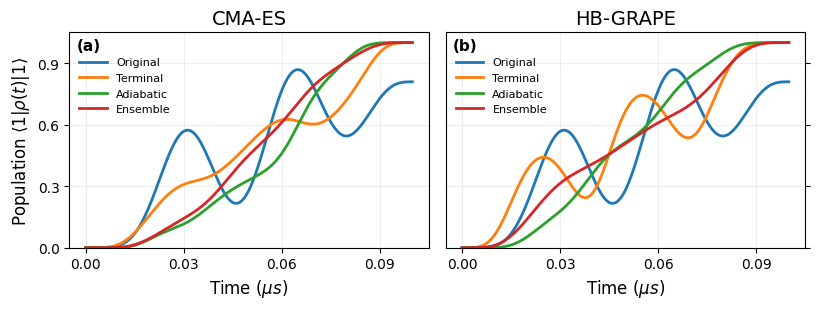

In [108]:
sx = qt.sigmax()
sz = qt.sigmaz()
ket0 = qt.basis(2, 0)
proj1 = qt.basis(2, 1) * qt.basis(2, 1).dag()

def make_interpolator(values: np.ndarray):
    values = np.asarray(values, dtype=float)
    def coefficient(t, _=None):
        return np.interp(t, CANONICAL_T, values)
    return coefficient

population_trajectories: dict[str, dict[str, np.ndarray]] = defaultdict(dict)
population_rows: list[dict[str, float]] = []

for algorithm, targets_dict in resampled_pulses.items():
    for target in TARGETS:
        pulse_entry = targets_dict.get(target)
        if not pulse_entry:
            continue

        omega = pulse_entry['omega']
        delta = pulse_entry['delta']
        hamiltonian = [
            [0.5 * sx, make_interpolator(omega)],
            [0.5 * sz, make_interpolator(delta)],
        ]

        result = qt.sesolve(hamiltonian, ket0, CANONICAL_T, e_ops=[proj1])
        population = np.clip(np.real(result.expect[0]), 0.0, 1.0)

        population_trajectories[algorithm][target] = population
        population_rows.append({
            'algorithm': algorithm,
            'target': target,
            'final_population': population[-1],
            'max_population': population.max(),
        })

population_fig, population_axes = plt.subplots(1, 2, figsize=(8.3, 3.2), sharex=True, sharey=True)

for col, algorithm in enumerate(['CMA-ES', 'GRAPE']):
    ax = population_axes[col]
    trajectories = population_trajectories.get(algorithm, {})
    for target in TARGETS:
        population = trajectories.get(target)
        print(f'{algorithm} - {target} final time infidelity:',1-population[-1])
        if population is None:
            continue
        ax.plot(CANONICAL_T, population,
                color=color_for(target), label=display_name(target), linewidth=2)

    ax.set_title(f'{algorithm}', fontsize=14)
    if algorithm == 'GRAPE':
        ax.set_title(f'HB-{algorithm}', fontsize=14)
    ax.set_xlabel(TIME_LABEL, fontsize=12)
    if col == 0:
        ax.set_ylabel(r'Population $\langle 1 | \rho(t) | 1 \rangle$', fontsize=12)
    ax.set_ylim(0.0, 1.05)
    ax.grid(alpha=0.2)

# legend (left panel)
handles, labels = population_axes[0].get_legend_handles_labels()
if handles:
    population_axes[0].legend(handles, labels, loc='upper left',bbox_to_anchor=(0.0, 0.93), frameon=False, handlelength=2.5, fontsize=8)
    population_axes[1].legend(handles, labels, loc='upper left',bbox_to_anchor=(0.0, 0.93), frameon=False, handlelength=2.5, fontsize=8)

# ticks, grids, right ticks on right panel
population_axes[1].yaxis.tick_right()
for ax in population_axes.ravel():
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.grid(alpha=0.2)

# subpanel labels
population_axes[0].text(0.02, 0.92, '(a)', transform=population_axes[0].transAxes,
                        fontsize=11, fontweight='bold')
population_axes[1].text(0.02, 0.92, '(b)', transform=population_axes[1].transAxes,
                        fontsize=11, fontweight='bold')

population_fig.tight_layout()

population_path = OUTPUT_DIR / 'population_transfer.png'
population_fig.savefig(population_path, dpi=300, bbox_inches='tight')
print(f'Saved population transfer figure to {population_path}')

population_summary_df = pd.DataFrame(population_rows)

population_npz = {'t': CANONICAL_T}
for algorithm, trajectories in population_trajectories.items():
    for target, values in trajectories.items():
        population_npz[slugify(algorithm, target, 'population')] = values
np.savez(OUTPUT_DIR / 'population_transfer.npz', **population_npz)
print(f"Saved trajectories to {OUTPUT_DIR / 'population_transfer.npz'}")
# save as pdf
population_pdf_path = OUTPUT_DIR / 'population_transfer.pdf'
population_fig.savefig(population_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved population transfer figure to {population_pdf_path}')

Saved CMA-ES Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/results/cma_es_bloch_trajectories.png
Saved CMA-ES Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/results/cma_es_bloch_trajectories.pdf
Saved GRAPE Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/results/grape_bloch_trajectories.png
Saved GRAPE Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/results/grape_bloch_trajectories.pdf


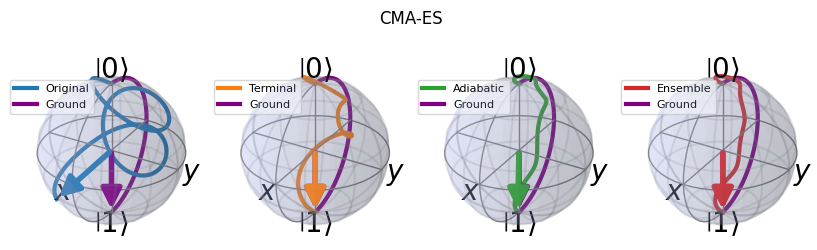

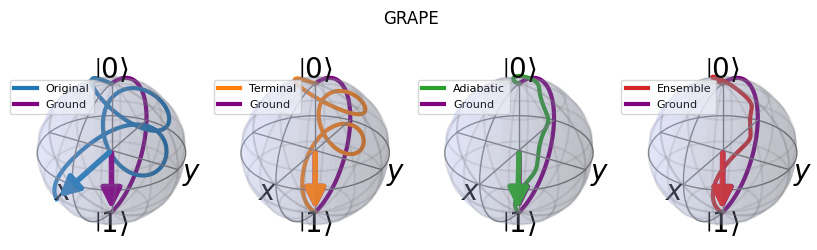

In [109]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

sy = qt.sigmay()
GROUND_COLOR = '#800080'


def simulate_bloch_trajectory(algorithm: str, target: str):
    pulses = resampled_pulses.get(algorithm, {}).get(target)
    if not pulses:
        return None

    omega = pulses['omega']
    delta = pulses['delta']

    hamiltonian = [
        [0.5 * sx, make_interpolator(omega)],
        [0.5 * sz, make_interpolator(delta)],
    ]

    result = qt.sesolve(hamiltonian, ket0, CANONICAL_T)
    states = result.states

    trajectory = {
        'sx': np.real(qt.expect(sx, states)),
        'sy': np.real(qt.expect(sy, states)),
        'sz': np.real(qt.expect(sz, states)),
    }

    field = np.vstack((omega, np.zeros_like(omega), delta))
    norms = np.linalg.norm(field, axis=0)
    ground_vec = np.zeros_like(field)
    mask = norms > 0
    ground_vec[:, mask] = -field[:, mask] / norms[mask]
    if np.any(~mask):
        ground_vec[:, ~mask] = np.array([[0.0], [0.0], [1.0]])

    trajectory['ground_sx'] = ground_vec[0]
    trajectory['ground_sy'] = ground_vec[1]
    trajectory['ground_sz'] = ground_vec[2]
    return trajectory


def plot_bloch_grid(algorithm: str):
    fig = plt.figure(figsize=(8.3, 2.5))
    axes = [
        fig.add_subplot(1, len(TARGETS), idx + 1, projection='3d')
        for idx in range(len(TARGETS))
    ]

    for idx, target in enumerate(TARGETS):
        ax = axes[idx]
        handles = []
        labels = [] 
        trajectory = simulate_bloch_trajectory(algorithm, target)
        if trajectory is None:
            ax.set_axis_off()
            ax.text2D(0.5, 0.5, 'Missing data', transform=ax.transAxes, ha='center', va='center')
            continue

        bloch = qt.Bloch(fig=fig, axes=ax)
        # bloch.line_color = [color_for(target), GROUND_COLOR]
        line_width = [3,3]
        bloch.sphere_color = "#b7c0f342"
        bloch.point_color = [GROUND_COLOR, color_for(target)]
        bloch.point_marker = ['o', 'o']
        bloch.point_size = [0, 0]
        bloch.vector_color = [GROUND_COLOR,color_for(target)]
        bloch.vector_width = 4
        bloch.vector_mutation = 30
        bloch.add_points([trajectory['ground_sx'], trajectory['ground_sy'], trajectory['ground_sz']], meth='l', )
        bloch.add_points([trajectory['sx'], trajectory['sy'], trajectory['sz']], meth='l')
        bloch.add_vectors([trajectory['ground_sx'][-1], trajectory['ground_sy'][-1], trajectory['ground_sz'][-1]])
        bloch.add_vectors([trajectory['sx'][-1], trajectory['sy'][-1], trajectory['sz'][-1]])        
        bloch.render()
        for i,line in enumerate(ax.lines[2:4]):
            line.set_linewidth(line_width[i])
        handles.append(Line2D([0], [0], color=color_for(target), lw=line_width[0], linestyle='-'))
        handles.append(Line2D([0], [0], color=GROUND_COLOR, lw=line_width[1], linestyle='-'))
        labels.append(display_name(target))
        labels.append('Ground')
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, 0.95), fontsize=8)
    
    fig.suptitle(f'{algorithm}')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


cma_fig = plot_bloch_grid('CMA-ES')
cma_path = OUTPUT_DIR / 'cma_es_bloch_trajectories.png'
cma_fig.savefig(cma_path, dpi=300, bbox_inches='tight')
print(f'Saved CMA-ES Bloch spheres to {cma_path}')
#save as pdf
cma_pdf_path = OUTPUT_DIR / 'cma_es_bloch_trajectories.pdf'
cma_fig.savefig(cma_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved CMA-ES Bloch spheres to {cma_pdf_path}')

grape_fig = plot_bloch_grid('GRAPE')
grape_path = OUTPUT_DIR / 'grape_bloch_trajectories.png'
grape_fig.savefig(grape_path, dpi=300, bbox_inches='tight')
print(f'Saved GRAPE Bloch spheres to {grape_path}')
#save as pdf
grape_pdf_path = OUTPUT_DIR / 'grape_bloch_trajectories.pdf'
grape_fig.savefig(grape_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved GRAPE Bloch spheres to {grape_pdf_path}')




Saved combined Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/results/bloch_trajectories_combined.png
Saved combined Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/results/bloch_trajectories_combined.pdf


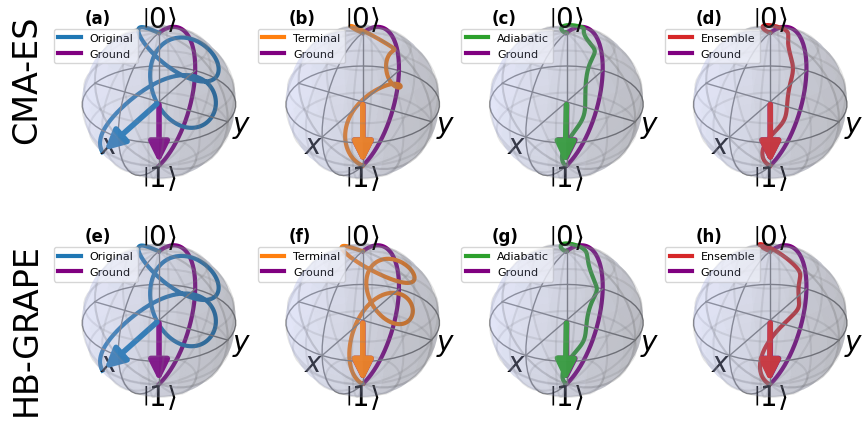

In [110]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# --- helper: render one row of Bloch spheres into provided axes ---
def _render_bloch_row(fig, axes_row, algorithm: str):
    for idx, target in enumerate(TARGETS):
        ax = axes_row[idx]
        handles, labels = [], []

        trajectory = simulate_bloch_trajectory(algorithm, target)
        if trajectory is None:
            ax.set_axis_off()
            ax.text2D(0.5, 0.5, 'Missing data', transform=ax.transAxes,
                      ha='center', va='center')
            continue

        bloch = qt.Bloch(fig=fig, axes=ax)
        line_width = [3, 3]
        bloch.sphere_color = "#b7c0f342"
        bloch.point_color = [GROUND_COLOR, color_for(target)]
        bloch.point_marker = ['o', 'o']
        bloch.point_size = [0, 0]
        bloch.vector_color = [GROUND_COLOR, color_for(target)]
        bloch.vector_width = 4
        bloch.vector_mutation = 30

        bloch.add_points(
            [trajectory['ground_sx'], trajectory['ground_sy'], trajectory['ground_sz']],
            meth='l'
        )
        bloch.add_points(
            [trajectory['sx'], trajectory['sy'], trajectory['sz']],
            meth='l'
        )
        bloch.add_vectors([
            trajectory['ground_sx'][-1], trajectory['ground_sy'][-1], trajectory['ground_sz'][-1]
        ])
        bloch.add_vectors([
            trajectory['sx'][-1], trajectory['sy'][-1], trajectory['sz'][-1]
        ])
        bloch.render()

        for i, line in enumerate(ax.lines[2:4]):
            line.set_linewidth(line_width[i])

        handles.append(Line2D([0], [0], color=color_for(target), lw=line_width[0], linestyle='-'))
        handles.append(Line2D([0], [0], color=GROUND_COLOR, lw=line_width[1], linestyle='-'))
        labels.append(display_name(target))
        labels.append('Ground')
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, 0.95), fontsize=8)


# --- combined figure: two rows, one for each algorithm ---
ncols = len(TARGETS)
combined_fig = plt.figure(figsize=(8.3, 5))
gs = GridSpec(2, ncols, figure=combined_fig)

axes_top = [combined_fig.add_subplot(gs[0, j], projection='3d') for j in range(ncols)]
axes_bot = [combined_fig.add_subplot(gs[1, j], projection='3d') for j in range(ncols)]

_render_bloch_row(combined_fig, axes_top, 'CMA-ES')
_render_bloch_row(combined_fig, axes_bot, 'GRAPE')

all_axes = axes_top + axes_bot
for i, ax in enumerate(all_axes):
    label = f"({chr(97 + i)})" 
    ax.text2D(0.1, 0.95, label, transform=ax.transAxes, fontsize=12, fontweight='bold')
# row titles
combined_fig.text(0.0, 0.75, 'CMA-ES', ha='right', va='center', fontsize=24,rotation=90)
combined_fig.text(0.0, 0.25, 'HB-GRAPE', ha='right', va='center', fontsize=24,rotation=90)

combined_fig.tight_layout(rect=[0, 0, 1, 0.96])

combined_path_png = OUTPUT_DIR / 'bloch_trajectories_combined.png'
combined_path_pdf = OUTPUT_DIR / 'bloch_trajectories_combined.pdf'
combined_fig.savefig(combined_path_png, dpi=300, bbox_inches='tight')
combined_fig.savefig(combined_path_pdf, dpi=300, bbox_inches='tight')
print(f'Saved combined Bloch spheres to {combined_path_png}')
print(f'Saved combined Bloch spheres to {combined_path_pdf}')


In [111]:
# Compute infidelity heatmaps for CMA-ES and GRAPE pulses (100x100 grid)
if 'resampled_pulses' not in globals():
    raise RuntimeError('Run the pulse processing cell before computing heatmaps.')

AREA_PI_GRID = np.linspace(0.1, 6.0, 100)
# Determine global detuning span across all pulses (rad/us)
detuning_max = 0 
for algorithm_dict in resampled_pulses.values():
    for target_entry in algorithm_dict.values():
        detuning_max = max(detuning_max, np.max(np.abs(target_entry['delta'])))
if detuning_max <= 0.0:
    detuning_max = 0.1
DETUNING_GRID = np.linspace(-detuning_max*0.5, detuning_max*0.5, 101)

solver_options = qt.Options(atol=1e-7, rtol=1e-7, nsteps=1000, store_states=False)

heatmap_results = {
    'grid': {
        'area_pi': AREA_PI_GRID,
        'detuning': DETUNING_GRID,
    },
    'data': {'CMA-ES': {}, 'GRAPE': {}},
}

for algorithm in ['CMA-ES', 'GRAPE']:
    algorithm_pulses = resampled_pulses.get(algorithm, {})
    for target in TARGETS:
        entry = algorithm_pulses.get(target)
        if entry is None:
            continue
        omega = np.asarray(entry['omega'], dtype=float)
        delta = np.asarray(entry['delta'], dtype=float)

        area_nom = float(np.trapezoid(omega, CANONICAL_T))
        if np.isclose(area_nom, 0.0):
            raise ValueError(f'Omega area is zero for {algorithm} | {target}.')
        omega_unit = omega / area_nom  # area = 1

        heat = np.empty((DETUNING_GRID.size, AREA_PI_GRID.size), dtype=float)

        for i_det, det_shift in enumerate(DETUNING_GRID):
            delta_shifted = delta + det_shift
            delta_func = make_interpolator(delta_shifted)
            for j_area, area_pi in enumerate(AREA_PI_GRID):
                target_area = float(area_pi * np.pi)
                omega_scaled = omega_unit * target_area
                omega_func = make_interpolator(omega_scaled)
                H = [
                    [0.5 * sx, omega_func],
                    [0.5 * sz, delta_func],
                ]
                result = qt.sesolve(H, ket0, CANONICAL_T, e_ops=[proj1], options=solver_options)
                pop1 = np.clip(np.real(result.expect[0][-1]), 0.0, 1.0)
                heat[i_det, j_area] = max(1.0 - pop1, 1e-12)

        heatmap_results['data'][algorithm][target] = heat
        print(f'Computed heatmap for {algorithm} | {target}')

print('Heatmap computation complete.')

/home/yehon/projects/grape-crab-qoc/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Computed heatmap for CMA-ES | original
Computed heatmap for CMA-ES | terminal
Computed heatmap for CMA-ES | adiabatic
Computed heatmap for CMA-ES | ensemble
Computed heatmap for GRAPE | original
Computed heatmap for GRAPE | terminal
Computed heatmap for GRAPE | adiabatic
Computed heatmap for GRAPE | ensemble
Heatmap computation complete.


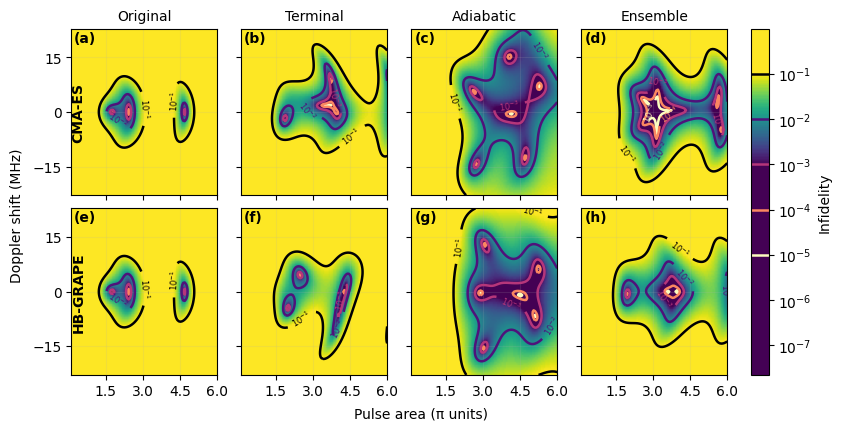

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# --- NEW: custom colormap for log10 data -------------------------------------
def make_flat_viridis_for_log(log_vmin, log_v1, log_v2, log_vmax, n=256):
    """
    Build a colormap for *log10-scaled images*:
      flat viridis-dark up to log_v1,
      full viridis between log_v1..log_v2,
      flat viridis-yellow above log_v2.
    Positions are specified in the [log_vmin, log_vmax] coordinate.
    """
    if not (log_vmin < log_v1 < log_v2 < log_vmax):
        raise ValueError("Require log_vmin < log_v1 < log_v2 < log_vmax")

    # map log thresholds to [0,1] colormap coordinate
    p1 = (log_v1 - log_vmin) / (log_vmax - log_vmin)
    p2 = (log_v2 - log_vmin) / (log_vmax - log_vmin)

    vir = plt.cm.viridis(np.linspace(0, 1, n))
    low, high = vir[0], vir[-1]

    pos_mid = p1 + (p2 - p1) * np.linspace(0, 1, n)  # where viridis varies
    pos = np.concatenate(([0.0, p1], pos_mid, [p2, 1.0]))
    cols = np.vstack([np.tile(low, (2, 1)), vir, np.tile(high, (2, 1))])

    return LinearSegmentedColormap.from_list("flat_viridis_log", list(zip(pos, cols)))
# -----------------------------------------------------------------------------

# Plot CMA-ES (top) and GRAPE (bottom) infidelity heatmaps with contours
if 'heatmap_results' not in globals():
    raise RuntimeError('Run the heatmap computation cell first.')

area_pi = heatmap_results['grid']['area_pi']
detuning = heatmap_results['grid']['detuning']
X, Y = np.meshgrid(area_pi, detuning)

# global color scaling on log10 data
log_values = []
for alg in ['CMA-ES', 'GRAPE']:
    for target in TARGETS:
        heat = heatmap_results['data'].get(alg, {}).get(target)
        if heat is not None:
            log_values.append(np.log10(heat))
if not log_values:
    raise RuntimeError('No heatmap data available for plotting.')

all_logs = np.concatenate([v.ravel() for v in log_values])
log_vmin = float(np.min(all_logs))
log_vmax = float(np.max(all_logs))

# --- NEW: thresholds and custom cmap (in log10 units) ------------------------
v1, v2 = 1e-3, 1e-1
flat_cmap = make_flat_viridis_for_log(log_vmin, np.log10(v1), np.log10(v2), log_vmax)
# -----------------------------------------------------------------------------

# sparser contour levels for readability (labeled)
contour_levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
valid_levels = contour_levels[
    (np.log10(contour_levels) >= log_vmin) & (np.log10(contour_levels) <= log_vmax)
]

fig, axes = plt.subplots(
    2, len(TARGETS), figsize=(8.3, 4.2),
    sharex=True, sharey=True, constrained_layout=True
)

last_contour = None
for row, algorithm in enumerate(['CMA-ES', 'GRAPE']):
    for col, target in enumerate(TARGETS):
        ax = axes[row, col]
        heat = heatmap_results['data'].get(algorithm, {}).get(target)
        if heat is None:
            ax.set_axis_off()
            continue

        log_heat = np.log10(heat)
        im = ax.imshow(
            log_heat, origin='lower', aspect='auto',
            extent=[area_pi[0], area_pi[-1], detuning[0]/(2*np.pi), detuning[-1]/(2*np.pi)],
            cmap=flat_cmap, vmin=log_vmin, vmax=log_vmax   # <-- use custom cmap
        )

        if valid_levels.size:
            cs = ax.contour(
                X, Y/(2*np.pi), log_heat,
                levels=np.log10(valid_levels),
                cmap='magma_r', linewidths=1.8
            )
            ax.clabel(cs, fmt=lambda v: rf"$10^{{{int(round(v))}}}$",
                      fontsize=6, inline=True)
            last_contour = cs

        if row == 0:
            ax.set_title(display_name(target), fontsize=10)

        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.grid(alpha=0.15)

fig.supxlabel('Pulse area (π units)', fontsize=10)
fig.supylabel('Doppler shift (MHz)', fontsize=10)

# Row labels INSIDE first-column axes to avoid reserving outer margin
axes[0, 0].text(0.05, 0.5, 'CMA-ES', transform=axes[0, 0].transAxes,
                rotation=90, va='center', ha='center', fontsize=10, fontweight='bold')
axes[1, 0].text(0.05, 0.5, 'HB-GRAPE', transform=axes[1, 0].transAxes,
                rotation=90, va='center', ha='center', fontsize=10, fontweight='bold')

for i, ax in enumerate(axes.ravel()):
    ax.text(0.02, 0.92, f"({chr(97 + i)})",
            transform=ax.transAxes, fontsize=10, fontweight='bold')


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), location='right',
                    fraction=0.028, pad=0.02)
tick_min = int(np.ceil(log_vmin))
tick_max = int(np.floor(log_vmax))
cbar.set_ticks(list(range(tick_min, tick_max + 1)))
cbar.set_ticklabels([rf"$10^{{{t}}}$" for t in range(tick_min, tick_max + 1)])
cbar.set_label('Infidelity', fontsize=10)


if last_contour is not None:
    cbar.add_lines(last_contour)

plt.show()


Method: CMA-ES Target: original min infidelity: 4.810670745758472e-06 at area_pi: 2.4242424242424243 detuning (MHz): 0.0
Method: GRAPE Target: original min infidelity: 4.810670745758472e-06 at area_pi: 2.4242424242424243 detuning (MHz): 0.0
Method: CMA-ES Target: terminal min infidelity: 2.3423187478499585e-07 at area_pi: 3.496969696969697 detuning (MHz): 1.8308070216728192
Method: GRAPE Target: terminal min infidelity: 1.2468808170407186e-06 at area_pi: 4.271717171717172 detuning (MHz): 0.0
Method: CMA-ES Target: adiabatic min infidelity: 3.575365038699374e-06 at area_pi: 4.152525252525252 detuning (MHz): -0.4577017554182048
Method: GRAPE Target: adiabatic min infidelity: 1.491411647513985e-07 at area_pi: 4.5101010101010095 detuning (MHz): -0.9154035108364096
Method: CMA-ES Target: ensemble min infidelity: 2.226310247266383e-08 at area_pi: 3.198989898989899 detuning (MHz): -0.4577017554182048
Method: GRAPE Target: ensemble min infidelity: 3.6232825939563895e-07 at area_pi: 3.973737373

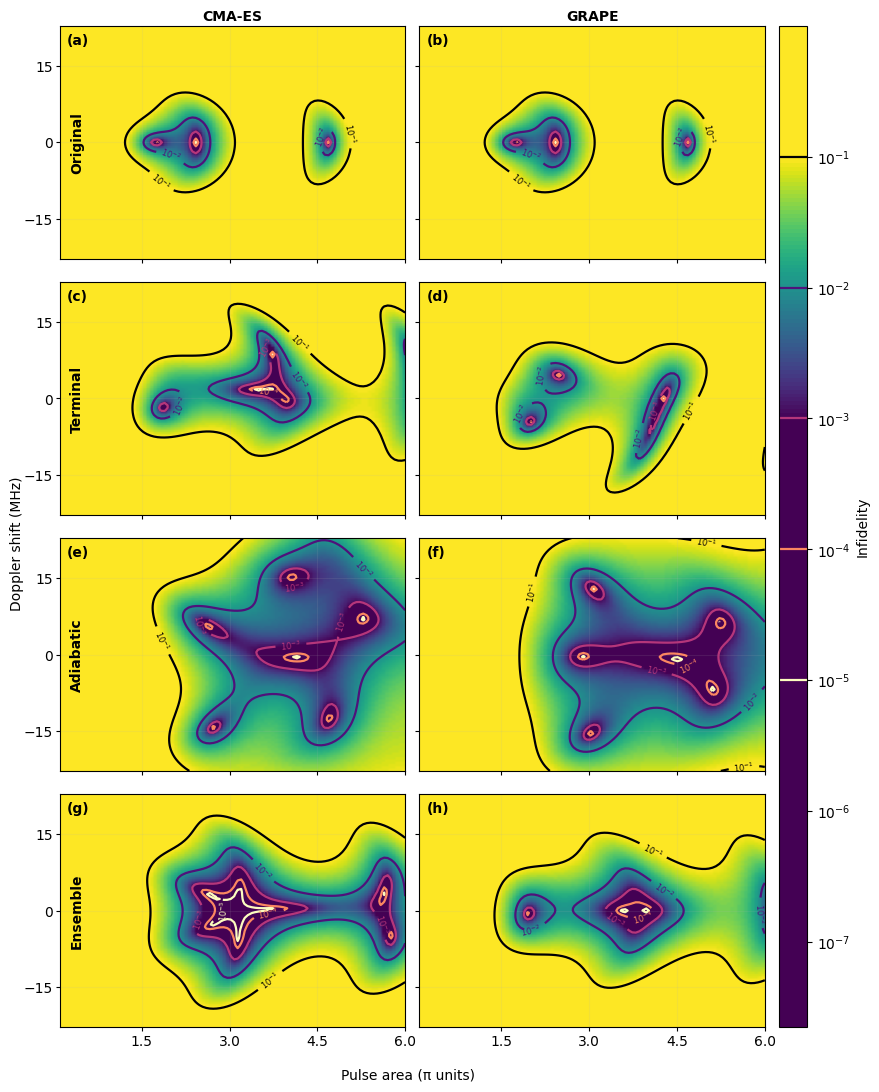

In [113]:
# sparser contour levels for readability (labeled)
contour_levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
valid_levels = contour_levels[
    (np.log10(contour_levels) >= log_vmin) & (np.log10(contour_levels) <= log_vmax)
]

fig = plt.figure(figsize=(8.3, 11))
gs = fig.add_gridspec(
    len(TARGETS), 3,
    width_ratios=[1, 1, 0.08],
    wspace=0.06, hspace=0.1,
    left=0.08, right=0.98, bottom=0.06, top=0.97
)
axes = np.array([[fig.add_subplot(gs[r, c]) for c in range(2)] for r in range(len(TARGETS))])
cax = fig.add_subplot(gs[:, -1])

algorithms = ['CMA-ES', 'GRAPE']
last_contour = None
im = None

for row, target in enumerate(TARGETS):
    target_name = display_name(target)
    for col, algorithm in enumerate(algorithms):
        ax = axes[row, col]
        heat = heatmap_results['data'].get(algorithm, {}).get(target)
        if heat is None:
            ax.set_axis_off()
            continue

        log_heat = np.log10(heat)
        print('Method:', algorithm, 'Target:', target, 'min infidelity:', np.min(heat),
              'at area_pi:', area_pi[np.unravel_index(np.argmin(heat), heat.shape)[1]],
              'detuning (MHz):', detuning[np.unravel_index(np.argmin(heat), heat.shape)[0]]/(2*np.pi))
        im = ax.imshow(
            log_heat, origin='lower', aspect='auto',
            extent=[area_pi[0], area_pi[-1], detuning[0]/(2*np.pi), detuning[-1]/(2*np.pi)],
            cmap=flat_cmap, vmin=log_vmin, vmax=log_vmax
        )

        if valid_levels.size:
            cs = ax.contour(
                X, Y/(2*np.pi), log_heat,
                levels=np.log10(valid_levels),
                cmap='magma_r', linewidths=1.6
            )
            ax.clabel(cs, fmt=lambda v: rf"$10^{{{int(round(v))}}}$",
                      fontsize=6, inline=True)
            last_contour = cs

        if row == 0:
            ax.set_title(algorithm, fontsize=10, pad=4, fontweight='bold')

        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        if row != len(TARGETS) - 1:
            ax.set_xticklabels([])
        if col == 1:
            ax.set_yticklabels([])
        ax.tick_params(length=3, pad=2)
        ax.grid(alpha=0.12)

    axes[row, 0].text(0.05, 0.5, target_name,
                      transform=axes[row, 0].transAxes,
                      rotation=90, va='center', ha='center',
                      fontsize=10, fontweight='bold')

fig.supxlabel('Pulse area (π units)', fontsize=10)
fig.supylabel('Doppler shift (MHz)', fontsize=10)

for i, ax in enumerate(axes.ravel()):
    ax.text(0.02, 0.92, f"({chr(97 + i)})", transform=ax.transAxes,
            fontsize=10, fontweight='bold')

if im is None:
    raise RuntimeError('No heatmap data available for plotting.')

cbar = fig.colorbar(im, cax=cax)
tick_min = int(np.ceil(log_vmin))
tick_max = int(np.floor(log_vmax))
cbar.set_ticks(list(range(tick_min, tick_max + 1)))
cbar.set_ticklabels([rf"$10^{{{t}}}$" for t in range(tick_min, tick_max + 1)])
cbar.set_label('Infidelity', fontsize=10)

if last_contour is not None:
    cbar.add_lines(last_contour)

plt.show()



In [114]:
# save figure as png and pdf
heatmap_png_path = OUTPUT_DIR / 'infidelity_heatmaps.png'
fig.savefig(heatmap_png_path, dpi=300, bbox_inches='tight')
print(f'Saved infidelity heatmaps to {heatmap_png_path}')
heatmap_pdf_path = OUTPUT_DIR / 'infidelity_heatmaps.pdf'
fig.savefig(heatmap_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved infidelity heatmaps to {heatmap_pdf_path}')

Saved infidelity heatmaps to /home/yehon/projects/grape-crab-qoc/results/results/infidelity_heatmaps.png
Saved infidelity heatmaps to /home/yehon/projects/grape-crab-qoc/results/results/infidelity_heatmaps.pdf


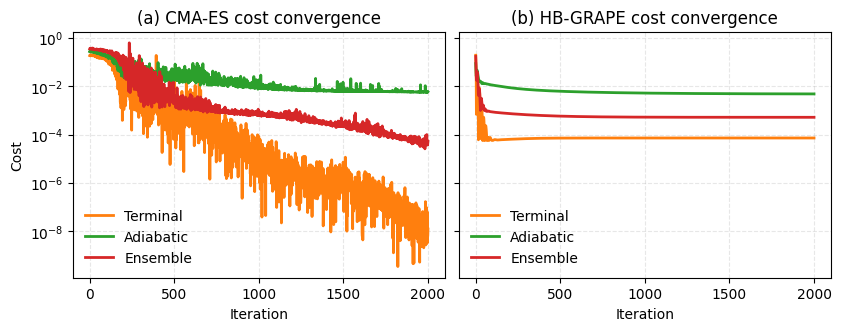

In [126]:
# Compare cost histories: (a) CMA-ES vs (b) HB-GRAPE on log scale
cma_hist_path = OUTPUT_DIR / 'cma_es_cost_histories.npz'
hb_hist_path = OUTPUT_DIR / 'hb_grape_cost_histories.npz'
if not cma_hist_path.exists() or not hb_hist_path.exists():
    raise FileNotFoundError('Run the CMA-ES and HB-GRAPE notebooks to generate cost history files first.')

with np.load(cma_hist_path) as data:
    cma_histories = {key: np.asarray(data[key], dtype=float) for key in data.files}
with np.load(hb_hist_path) as data:
    hb_histories = {key: np.asarray(data[key], dtype=float) for key in data.files}

CMA_TARGET_MAP = {
    'Fidelity': 'Terminal',
    'Adiabatic':'Adiabatic',
    'Ensemble': 'Ensemble',
}
HB_LABEL_MAP = {
    'terminal': 'Terminal',
    'path':     'Adiabatic',
    'ensemble': 'Ensemble',
}


# --- Consistent thesis color scheme ---
COLOR_MAP = {
    'Original':  '#1f77b4',  # blue
    'Adiabatic': '#2ca02c',  # green
    'Terminal':  '#ff7f0e',  # orange
    'Ensemble':  '#d62728',  # red
    'Fidelity':  '#ff7f0e',  # same as Terminal
}

# --- Plot setup ---
fig, axes = plt.subplots(1, 2, figsize=(8.3, 3.2), constrained_layout=True,sharey=True)

# === (a) CMA-ES ===
ax_cma = axes[0]
for name in cma_histories.keys():
    values = np.clip(np.asarray(cma_histories[name], dtype=float), 1e-12, None)
    iterations = np.arange(1, values.size + 1)
    color_key = CMA_TARGET_MAP.get(name, name)
    color = COLOR_MAP.get(color_key, '#808080')
    if color != '#808080':
        ax_cma.plot(iterations, values, label=color_key, color=color, linewidth=2)

ax_cma.set_yscale('log')
ax_cma.set_xlabel('Iteration')
ax_cma.set_ylabel('Cost')
ax_cma.set_title('(a) CMA-ES cost convergence')
ax_cma.grid(True, linestyle='--', alpha=0.3)
ax_cma.legend(frameon=False)


# === (b) HB-GRAPE ===
ax_hb = axes[1]
for key in reversed(sorted(hb_histories.keys())):
    values = np.clip(np.asarray(hb_histories[key], dtype=float), 1e-12, None)
    iterations = np.arange(1, values.size + 1)
    label = HB_LABEL_MAP.get(key, key.title())
    color = COLOR_MAP.get(label, '#808080')
    ax_hb.plot(iterations, values, label=label, linewidth=2, color=color)
ax_hb.legend(frameon=False)
ax_hb.set_yscale('log')
ax_hb.set_xlabel('Iteration')
# ax_hb.set_ylabel()
ax_hb.set_title('(b) HB-GRAPE cost convergence')
ax_hb.grid(True, linestyle='--', alpha=0.3)


plt.show()


In [127]:
# Save heatmap figure as png and pdf
cost_png_path = OUTPUT_DIR / 'cost_convergence.png'
fig.savefig(cost_png_path, dpi=300, bbox_inches='tight')
print(f'Saved cost convergence figure to {cost_png_path}')
cost_pdf_path = OUTPUT_DIR / 'cost_convergence.pdf'
fig.savefig(cost_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved cost convergence figure to {cost_pdf_path}')

Saved cost convergence figure to /home/yehon/projects/grape-crab-qoc/results/results/cost_convergence.png
Saved cost convergence figure to /home/yehon/projects/grape-crab-qoc/results/results/cost_convergence.pdf


CMA-ES runtime summary:
   Terminal (CMA-ES): iterations=2000, runtime=47.29s
   Ensemble (CMA-ES): iterations=2000, runtime=1215.26s
  Adiabatic (CMA-ES): iterations=2000, runtime=152.14s
  alt_adi_1 (CMA-ES): iterations=2000, runtime=52.24s
  alt_adi_2 (CMA-ES): iterations=2000, runtime=149.75s
HB-GRAPE runtime summary:
   Terminal (HB-GRAPE): iterations=2000, runtime=80.53s
   Ensemble (HB-GRAPE): iterations=2000, runtime=2070.36s
  Adiabatic (HB-GRAPE): iterations=2000, runtime=168.42s
Saved runtime comparison figures to /home/yehon/projects/grape-crab-qoc/results/results/optimization_runtime_comparison.png and /home/yehon/projects/grape-crab-qoc/results/results/optimization_runtime_comparison.pdf


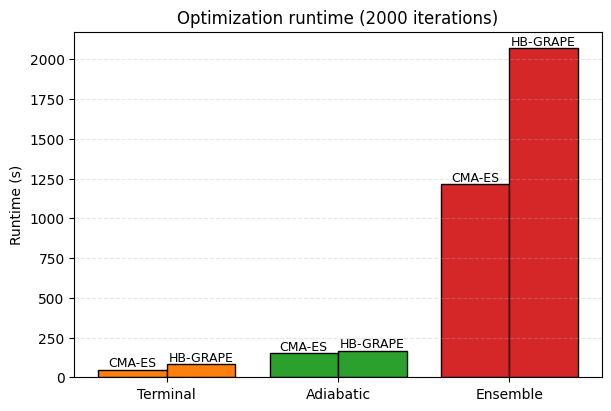

In [128]:
# Load and compare runtime summaries for CMA-ES vs HB-GRAPE at ~2000 iterations
cma_runtime_path = OUTPUT_DIR / 'cma_es_runtime_summary.npz'
hb_runtime_path = OUTPUT_DIR / 'hb_grape_runtime_summary.npz'
if not cma_runtime_path.exists() or not hb_runtime_path.exists():
    raise FileNotFoundError('Runtime summary files missing. Run optimization notebooks first.')

with np.load(cma_runtime_path) as data:
    cma_summary = {key: data[key] for key in data.files}
with np.load(hb_runtime_path) as data:
    hb_summary = {key: data[key] for key in data.files}

name_map = {
    'Fidelity': 'Terminal',
    'terminal': 'Terminal',
    'Adiabatic': 'Adiabatic',
    'adiabatic': 'Adiabatic',
    'Ensemble': 'Ensemble',
    'ensemble': 'Ensemble',
    'path': 'Adiabatic',
}

print('CMA-ES runtime summary:')
for key, arr in cma_summary.items():
    iters, runtime_s = arr
    print(f"  {name_map.get(key, key):>9} (CMA-ES): iterations={int(iters)}, runtime={runtime_s:.2f}s")

print('HB-GRAPE runtime summary:')
for key, arr in hb_summary.items():
    iters, runtime_s = arr
    print(f"  {name_map.get(key, key):>9} (HB-GRAPE): iterations={int(iters)}, runtime={runtime_s:.2f}s")

objectives = ['Terminal', 'Adiabatic', 'Ensemble']
color_map = {
    'Terminal': '#ff7f0e',
    'Adiabatic': '#2ca02c',
    'Ensemble': '#d62728',
}

cma_runtimes = []
hb_runtimes = []
for obj in objectives:
    cma_key = next((k for k in cma_summary if name_map.get(k, k) == obj), None)
    hb_key = next((k for k in hb_summary if name_map.get(k, k) == obj), None)
    cma_runtimes.append(cma_summary[cma_key][1] if cma_key else np.nan)
    hb_runtimes.append(hb_summary[hb_key][1] if hb_key else np.nan)

x = np.arange(len(objectives))
width = 0.4

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

bars1 = ax.bar(x - width/2, cma_runtimes, width, label='CMA-ES', color=[color_map[obj] for obj in objectives], alpha=1.0, edgecolor='black')
bars2 = ax.bar(x + width/2, hb_runtimes, width, label='HB-GRAPE', color=[color_map[obj] for obj in objectives], alpha=1.0, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(objectives)
ax.set_ylabel('Runtime (s)')
ax.set_title('Optimization runtime (2000 iterations)')
ax.grid(axis='y', linestyle='--', alpha=0.3)

for i, obj in enumerate(objectives):
    ax.text(x[i] - width/2, cma_runtimes[i] + 1e-2, 'CMA-ES', ha='center', va='bottom', fontsize=9)
    ax.text(x[i] + width/2, hb_runtimes[i] + 1e-2, 'HB-GRAPE', ha='center', va='bottom', fontsize=9)

runtime_png = OUTPUT_DIR / 'optimization_runtime_comparison.png'
runtime_pdf = OUTPUT_DIR / 'optimization_runtime_comparison.pdf'
fig.savefig(runtime_png, dpi=300, bbox_inches='tight')
fig.savefig(runtime_pdf, bbox_inches='tight')
print(f'Saved runtime comparison figures to {runtime_png} and {runtime_pdf}')

plt.show()

Adiabaticity metrics for CMA-ES pulses:
    original: mean=+9.800e-01, std=5.582e-01, max=+2.090e+00, min=+9.756e-03
    terminal: mean=+9.360e-01, std=4.677e-01, max=+2.318e+00, min=+3.239e-01
   adiabatic: mean=+6.609e-01, std=2.379e-01, max=+1.045e+00, min=+9.685e-04
    ensemble: mean=+9.072e-01, std=2.948e-01, max=+1.384e+00, min=+5.523e-03
Adiabaticity metrics for GRAPE pulses:
    original: mean=+9.800e-01, std=5.582e-01, max=+2.090e+00, min=+9.756e-03
    terminal: mean=+8.970e-01, std=5.163e-01, max=+2.485e+00, min=+5.817e-03
   adiabatic: mean=+6.378e-01, std=1.890e-01, max=+9.356e-01, min=+2.464e-08
    ensemble: mean=+8.828e-01, std=2.669e-01, max=+1.321e+00, min=+2.741e-01


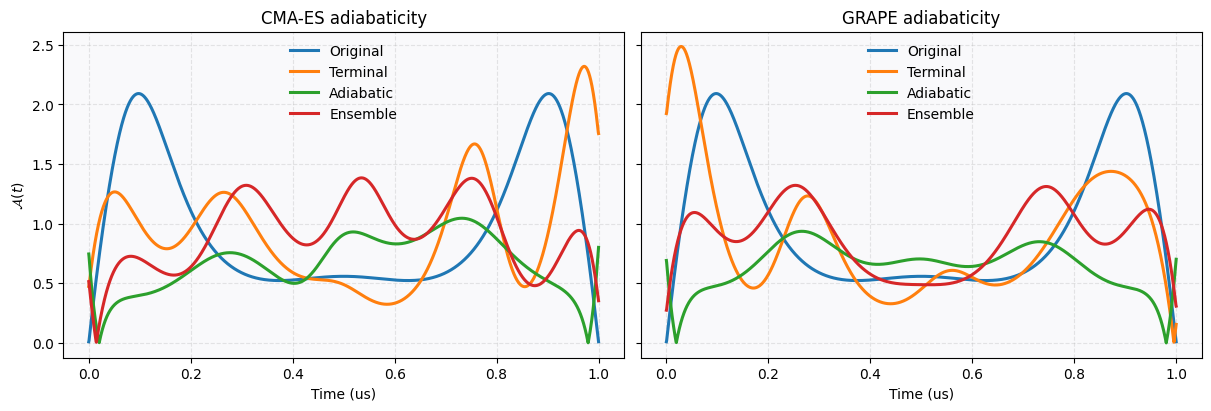

In [120]:
# Compute updated adiabaticity metric A(t) and visualize
if 'resampled_pulses' not in globals():
    raise RuntimeError('Run the pulse processing cell before computing adiabaticity.')

PLOT_COLORS = {
    'original': '#1f77b4',
    'terminal': '#ff7f0e',
    'adiabatic': '#2ca02c',
    'ensemble': '#d62728',
    'path': '#9467bd',
}

adiabaticity = {}
for algorithm, targets_dict in resampled_pulses.items():
    adiabaticity[algorithm] = {}
    for target, entry in targets_dict.items():
        omega = np.asarray(entry['omega'], dtype=float)
        delta = np.asarray(entry['delta'], dtype=float)

        domega_dt = np.gradient(omega, CANONICAL_T)
        ddelta_dt = np.gradient(delta, CANONICAL_T)
        numerator = np.abs(delta * domega_dt - omega * ddelta_dt)
        denom_base = omega**2 + delta**2
        denom = 2.0 * np.power(np.sqrt(denom_base), 3)*CANONICAL_T[-1]
        with np.errstate(divide='ignore', invalid='ignore'):
            metric = np.nan_to_num(numerator / denom, nan=0.0, posinf=0.0, neginf=0.0)
        adiabaticity[algorithm][target] = metric

for algorithm, targets_dict in adiabaticity.items():
    print(f"Adiabaticity metrics for {algorithm} pulses:")
    for target, metric in targets_dict.items():
        print(f"  {target:>10}: mean={metric.mean():+.3e}, std={metric.std():.3e}, max={metric.max():+.3e}, min={metric.min():+.3e}")

# Plot A(t) for CMA-ES and HB-GRAPE
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)

for idx, algorithm in enumerate(['CMA-ES', 'GRAPE']):
    ax = axes[idx]
    targets_dict = adiabaticity.get(algorithm, {})
    for target in TARGETS:
        metric = targets_dict.get(target)
        if metric is None:
            continue
        shade_color = PLOT_COLORS.get(target, '#7f7f7f')
        # ax.fill_between(CANONICAL_T, metric, color=shade_color, alpha=0.35, linewidth=0)
        ax.plot(CANONICAL_T/CANONICAL_T[-1], metric, label=display_name(target), color=shade_color, linewidth=2.2)
    # ax.set_yscale('log')
    ax.set_xlabel('Time (us)')
    if idx == 0:
        ax.set_ylabel(r'$\mathcal{A}(t)$')
    ax.set_title(f"{algorithm} adiabaticity")
    ax.set_facecolor('#f9f9fb')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(frameon=False)

plt.show()

In [121]:
# Save adiabaticity figure as png and pdf
adiabaticity_png = OUTPUT_DIR / 'adiabaticity_metric.png'
adiabaticity_pdf = OUTPUT_DIR / 'adiabaticity_metric.pdf'
fig.savefig(adiabaticity_png, dpi=300, bbox_inches='tight')
fig.savefig(adiabaticity_pdf, dpi=300, bbox_inches='tight')
print(f'Saved adiabaticity metric figures to {adiabaticity_png} and {adiabaticity_pdf}')

Saved adiabaticity metric figures to /home/yehon/projects/grape-crab-qoc/results/results/adiabaticity_metric.png and /home/yehon/projects/grape-crab-qoc/results/results/adiabaticity_metric.pdf
